In [1]:
%matplotlib widget
%load_ext autoreload
%autoreload 2
from src.folder_handler import *
from src.cort_processor import *
from src.cca_processor import *
from src.tdt_support import *
from src.plotter import *
from src.decoders import *
from src.utils import *
import pickle
import scipy as sio
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from src.wiener_filter import *
from matplotlib.pyplot import cm
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import os
import copy

# set paths/create objects

cp1 = day-0

cp2 = day-n

In [3]:
cp1_path = '/home/diya/Documents/rat-fes/data/filipe_data/N5/N5_170929_No Obstacles_s.mat'
cp2_path = '/home/diya/Documents/rat-fes/data/filipe_data/N5/N5_171001_No Obstacles_s.mat'

cp1 = CortProcessor(cp1_path)
cp2 = CortProcessor(cp2_path)

cca_object = CCAProcessor(cp1, cp2)

this is filipe data i belive
this is filipe data i belive
should be good to align
(8945, 11)
(8945, 5)
(8945, 23)
(8945, 5)


In [11]:
#subsampling list, percent of total data
subsample_list = [.005, .01, .02, .05, .1, 1.0]
nummy = cp2.data['rates'][0].shape[0]
newlist = [int(sub * nummy) for sub in subsample_list]

print(f'num_samples:{newlist}')

num_samples:[60, 120, 240, 601, 1203, 12039]


# getting day0 decoder
apply PCA, and then train wiener filter.
also get a day0-scaled-weights-decoder

In [9]:
#get day0 decoder weights, scaled + unscaled versions

day0_decoder, nada, naday, nadax = cp1.decode_angles(X=cp1.apply_PCA())
lowest_num_dimensions = cp1.num_components
print(np.average(nada, 1)[1])

X_tempy =cp1.apply_PCA(lowest_num_dimensions)
scaler = StandardScaler()
X_scale = scaler.fit_transform(np.squeeze(X_tempy))
day0_decoder_scale, nada, naday, nadax = cp1.decode_angles(X=[X_scale])

print(np.average(nada, 1)[1])

0.538
0.538


# getting JUST-PCA decoder
we subsample day-n data, apply PCA, and then train a wiener filter on it to spit out a decoder. Then we try decoder on the day2-test set

In [15]:
fixed_decoder_scores = []
pca_decoder_scores = []

for i in range(len(subsample_list)):
    sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
    sub_x_pca = cp2.apply_PCA(dims=lowest_num_dimensions, X=sub_x)
    pca_object = cp2.pca_object
    
    temp_h, nada, nadax, naday = cp2.decode_angles(X=sub_x_pca, Y=sub_y)
    
    testing_x = np.squeeze(cp2.data['rates'])
    test_x = np.squeeze(np.array(cp2.apply_PCA(dims=lowest_num_dimensions, transformer = pca_object)))
    test_y = np.squeeze(np.array(cp2.data['angles']))
    
    test_x_format, test_y_format = format_data(test_x, test_y)
    
    temp_y = test_wiener_filter(test_x_format, day0_decoder)
    fixed_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))
    
    temp_y = test_wiener_filter(test_x_format, temp_h)
    pca_decoder_scores.append(vaf(test_y_format[:,1], temp_y[:,1]))

print(fixed_decoder_scores)
print(pca_decoder_scores)

[-1.55, -1.38, -1.47, -1.75, -1.73, -1.44]
[-186.44, 0.32, 0.58, 0.7, 0.72, 0.78]


# cca decoder

In [44]:
cca_decoder_scores = []
cca_transformers=[]
new_cca_decoder_scores=[]
for i in range(len(subsample_list)):
    temp_cp2 = copy.deepcopy(cp2)
    sub_x2, sub_y2 = temp_cp2.subsample(percent = subsample_list[i])
    
    temp_cp2.data['rates'] = sub_x2
    temp_cp2.data['angles'] = sub_y2
    
    temp_cca = CCAProcessor(cp1, temp_cp2)
    
    pca_sub_x1, pca_sub_x2 = temp_cca.apply_PCA(preset_num_components=lowest_num_dimensions)
    temp_cca_transformer, nada = temp_cca.apply_CCA(preset_num_components = lowest_num_dimensions)
    
    cca_transformers.append(temp_cca_transformer)
    
    testing_x = np.squeeze(cp2.data['rates'])
    test_x = np.squeeze(np.array(cp2.apply_PCA(dims=lowest_num_dimensions, transformer = temp_cca.data['cp2']['pca_transformer'])))
    test_y = np.squeeze(np.array(cp2.data['angles']))
    
    test_x_format, test_y_format = format_data(test_x, test_y)
    nada, test_x_cca_space = temp_cca_transformer.transform(test_x, test_x)
    
    temp_x = temp_cca_transformer.inverse_transform(test_x_cca_space)
    
    temp_x_format, nada = format_data(temp_x, test_y)
    predic = test_wiener_filter(temp_x_format, day0_decoder)
    
    cca_decoder_scores.append(vaf(test_y_format[:,1], predic[:,1]))

should be good to align
(48, 11)
(48, 5)
(48, 23)
(48, 5)
should be good to align
(117, 11)
(117, 5)
(117, 23)
(117, 5)
should be good to align
(219, 11)
(219, 5)
(219, 23)
(219, 5)
should be good to align
(547, 11)
(547, 5)
(547, 23)
(547, 5)
should be good to align
(1005, 11)
(1005, 5)
(1005, 23)
(1005, 5)
should be good to align
(8945, 11)
(8945, 5)
(8945, 23)
(8945, 5)


In [46]:
cca_decoder_scores

[-1.1, -0.08, -0.12, -0.24, -0.74, 0.48]

# regression fit

In [50]:
r_scores = []

for i in range(len(subsample_list)):
    #subsample day-n unprocessed data
    sub_x, sub_y = cp2.subsample(percent = subsample_list[i])
    
    #apply PCA to subsampled data
    sub_x_pca = np.squeeze(cp2.apply_PCA(dims=lowest_num_dimensions, X=sub_x))
    #transform PCA subsample to day-0 shape
    nada, sub_x_cca_space = cca_transformers[i].transform(sub_x_pca, sub_x_pca)
    temp_x = cca_transformers[i].inverse_transform(sub_x_cca_space)
    #scale transformed data 
    scaler = StandardScaler()
    temp_x_scale = scaler.fit_transform(temp_x)

    wpost = ridge_fit(b0=day0_decoder_scale, x=temp_x_scale, y=np.squeeze(sub_y), my_alpha=100.0)
    
    
    ###now lets test on full dataset
    testing_x = np.squeeze(cp2.data['rates'])
    test_x = np.squeeze(np.array(cp2.apply_PCA(dims=lowest_num_dimensions, transformer = cp2.pca_object)))
    test_y = np.squeeze(np.array(cp2.data['angles']))
    
    nada, test_xx = cca_object.apply_CCA(cp2_x = test_x, transformer = cca_transformers[i])
    test_xx_scale = scaler.transform(test_xx)
    test_xx_scale_format, nada = format_data(test_xx_scale, test_y)
    temp_y = test_wiener_filter(test_xx_scale_format, wpost)
    
    i_love_you = vaf(test_y_format[:,1], temp_y[:,1])
    print(f'please for god sake: {i_love_you}')
    print('\n')
     
    
    r_scores.append(i_love_you)

initial_scoring is : -0.17
new_scoring is: 0.75
set num copmoentns
please for god sake: 0.4


initial_scoring is : 0.08
new_scoring is: 0.82
set num copmoentns
please for god sake: 0.55


initial_scoring is : 0.38
new_scoring is: 0.8
set num copmoentns
please for god sake: 0.65


initial_scoring is : -0.11
new_scoring is: 0.81
set num copmoentns
please for god sake: 0.72


initial_scoring is : -0.7
new_scoring is: 0.74
set num copmoentns
please for god sake: 0.71


initial_scoring is : 0.52
new_scoring is: 0.78
set num copmoentns
please for god sake: 0.78




Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
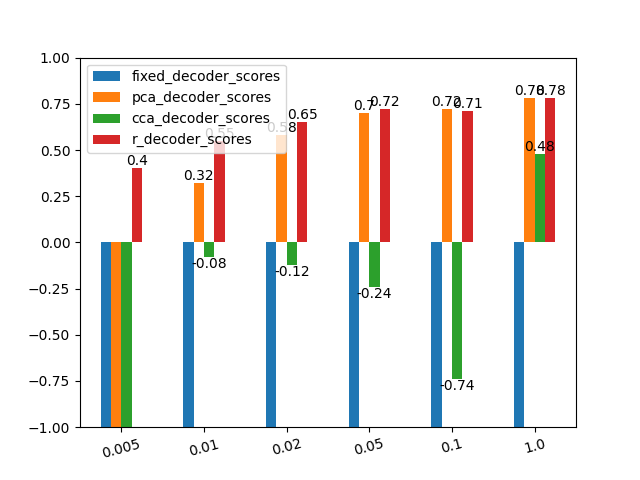

In [53]:
%matplotlib widget
%matplotlib widget

plot_dict = {}
plot_dict['fixed_decoder_scores'] = fixed_decoder_scores
plot_dict['pca_decoder_scores'] = pca_decoder_scores
plot_dict['cca_decoder_scores'] = cca_decoder_scores
plot_dict['r_decoder_scores'] = r_scores

index = subsample_list

df = pd.DataFrame(data=plot_dict, index=index)

  
# plot grouped bar chart
ax = df.plot.bar(rot=15)
ax.set_ylim(bottom=-1, top=1)
for container in ax.containers:
    ax.bar_label(container)

In [31]:
temp_cca = CCAProcessor(cp1, temp_cp2)


should be good to align
Singular matrix
did you run process() first.


TypeError: cannot unpack non-iterable NoneType object

In [34]:
x, y=temp_cp2.divide_into_gaits(bool_resample=False)

In [38]:
len(x[0])

6

In [37]:
len(y[0])


6